In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint
pp = pprint.PrettyPrinter(indent=4)

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.semi_supervised import LabelSpreading
from utils import visualize_silhouette
from typing import Tuple

### Data Import

In [2]:
# read in data and inspect it
df = pd.read_csv('./dat/online_shoppers_intention.csv.gz')
df.columns = [col.lower() for col in list(df.columns)]
print(f'Purchase intention data has {df.shape[0]} instances and {df.shape[1]} features')

Purchase intention data has 12330 instances and 18 features


In [3]:
df.head(5)

,administrative,administrative_duration,informational,informational_duration,productrelated,productrelated_duration,bouncerates,exitrates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype,weekend,revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   administrative           12330 non-null  int64  
 1   administrative_duration  12330 non-null  float64
 2   informational            12330 non-null  int64  
 3   informational_duration   12330 non-null  float64
 4   productrelated           12330 non-null  int64  
 5   productrelated_duration  12330 non-null  float64
 6   bouncerates              12330 non-null  float64
 7   exitrates                12330 non-null  float64
 8   pagevalues               12330 non-null  float64
 9   specialday               12330 non-null  float64
 10  month                    12330 non-null  object 
 11  operatingsystems         12330 non-null  int64  
 12  browser                  12330 non-null  int64  
 13  region                   12330 non-null  int64  
 14  traffictype           

In [5]:
# describe the numerical features
df.describe()

,administrative,administrative_duration,informational,informational_duration,productrelated,productrelated_duration,bouncerates,exitrates,pagevalues,specialday,operatingsystems,browser,region,traffictype
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [6]:
# describe the categorical features
for col in df.select_dtypes(['bool', 'object']).columns:
    print(f'Feature {col}\n{df[col].value_counts()}')
    print()

Feature month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: month, dtype: int64

Feature visitortype
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: visitortype, dtype: int64

Feature weekend
False    9462
True     2868
Name: weekend, dtype: int64

Feature revenue
False    10422
True      1908
Name: revenue, dtype: int64



In [7]:
df.isna().sum()

administrative             0
administrative_duration    0
informational              0
informational_duration     0
productrelated             0
productrelated_duration    0
bouncerates                0
exitrates                  0
pagevalues                 0
specialday                 0
month                      0
operatingsystems           0
browser                    0
region                     0
traffictype                0
visitortype                0
weekend                    0
revenue                    0
dtype: int64

### Task 1. Classification

Build a predictive classification model using data entries corresponding to the months of June—December as training set, and those corresponding to February—March as test set.

More specifically,
1. Fit a logistic regression and at least one other classification model. Find and explain important features.
2. Report and interpret the most meaningful classifications metrics
3. Show and explain the hyper-parameter fitting process.

Point breakdown:

- (10 points) Basic exploratory data analysis (EDA)
    - Appropriate univariate descriptive statistics and figures
    - Appropriate bi-variate descriptive statistics and figures
- (5 points) Advanced EDA
    - Free-response, shows us what they know!
- (5 points) Train/test split
- (10 points) Feature selection
- (15 points) Model fitting
- (5 points) Performance points


#### Data Partitioning

In [8]:
# split time-series into train and test sets
train = df[df['month'].isin(['June', 'Jul', 'Aug', 'Nov', 'Sep', 'Dec'])]
test = df[df['month'].isin(['Feb', 'Mar'])]
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (6326, 18)
Test shape: (2091, 18)


#### Exploratory Data Analysis

In [9]:
# pre-convert the booleans as integers
train_targets = pd.Series(train['revenue'].astype(int), name='target')
train_weekends = pd.Series(train['weekend'].astype(int), name='weekend_t')
train = pd.concat([train, train_targets, train_weekends], axis=1)
train.drop(['revenue', 'weekend'], axis=1, inplace=True)

test_targets = pd.Series(test['revenue'].astype(int), name='target')
test_weekends = pd.Series(test['weekend'].astype(int), name='weekend_t')
test = pd.concat([test, test_targets, test_weekends], axis=1)
test.drop(['revenue', 'weekend'], axis=1, inplace=True)

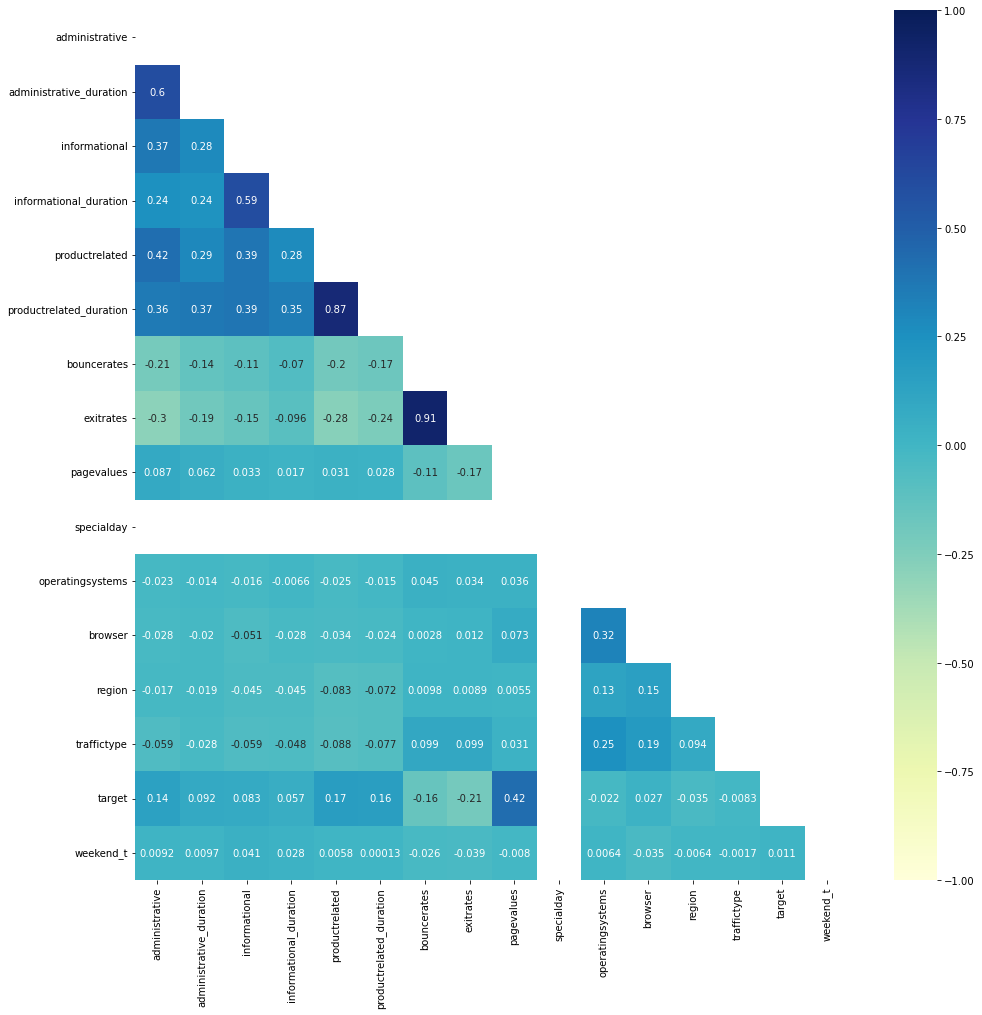

In [10]:
# check for highly correlated features
plt.figure(figsize=(16, 16))

# creating mask
mask = np.triu(np.ones_like(train.corr()))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='YlGnBu', annot=True, mask=mask);

💡 Observations of the correlation coefficients for each pair of features:
- `productrelated` and `productrelated_duration` look to have a high correlation coefficient (.87)
- `bouncerates` and `exitrates` look to have a high correlation coefficient (.91)

From these observations, we can drop highly correlated features. To do this, we want to maintain the features that have the strongest relationship with the target variable (revenue), so we elect to keep `productrelated` and `exitrates` since they exhibit stronger relationships in both the positive and negative directions. Hence, we will drop `productrelated_duration` and `bouncerates`.

In [11]:
# drop the secondary features
train = train.drop(['productrelated_duration', 'bouncerates'], axis=1)
test = test.drop(['productrelated_duration', 'bouncerates'], axis=1)

In [12]:
train.isna().sum()

administrative             0
administrative_duration    0
informational              0
informational_duration     0
productrelated             0
exitrates                  0
pagevalues                 0
specialday                 0
month                      0
operatingsystems           0
browser                    0
region                     0
traffictype                0
visitortype                0
target                     0
weekend_t                  0
dtype: int64

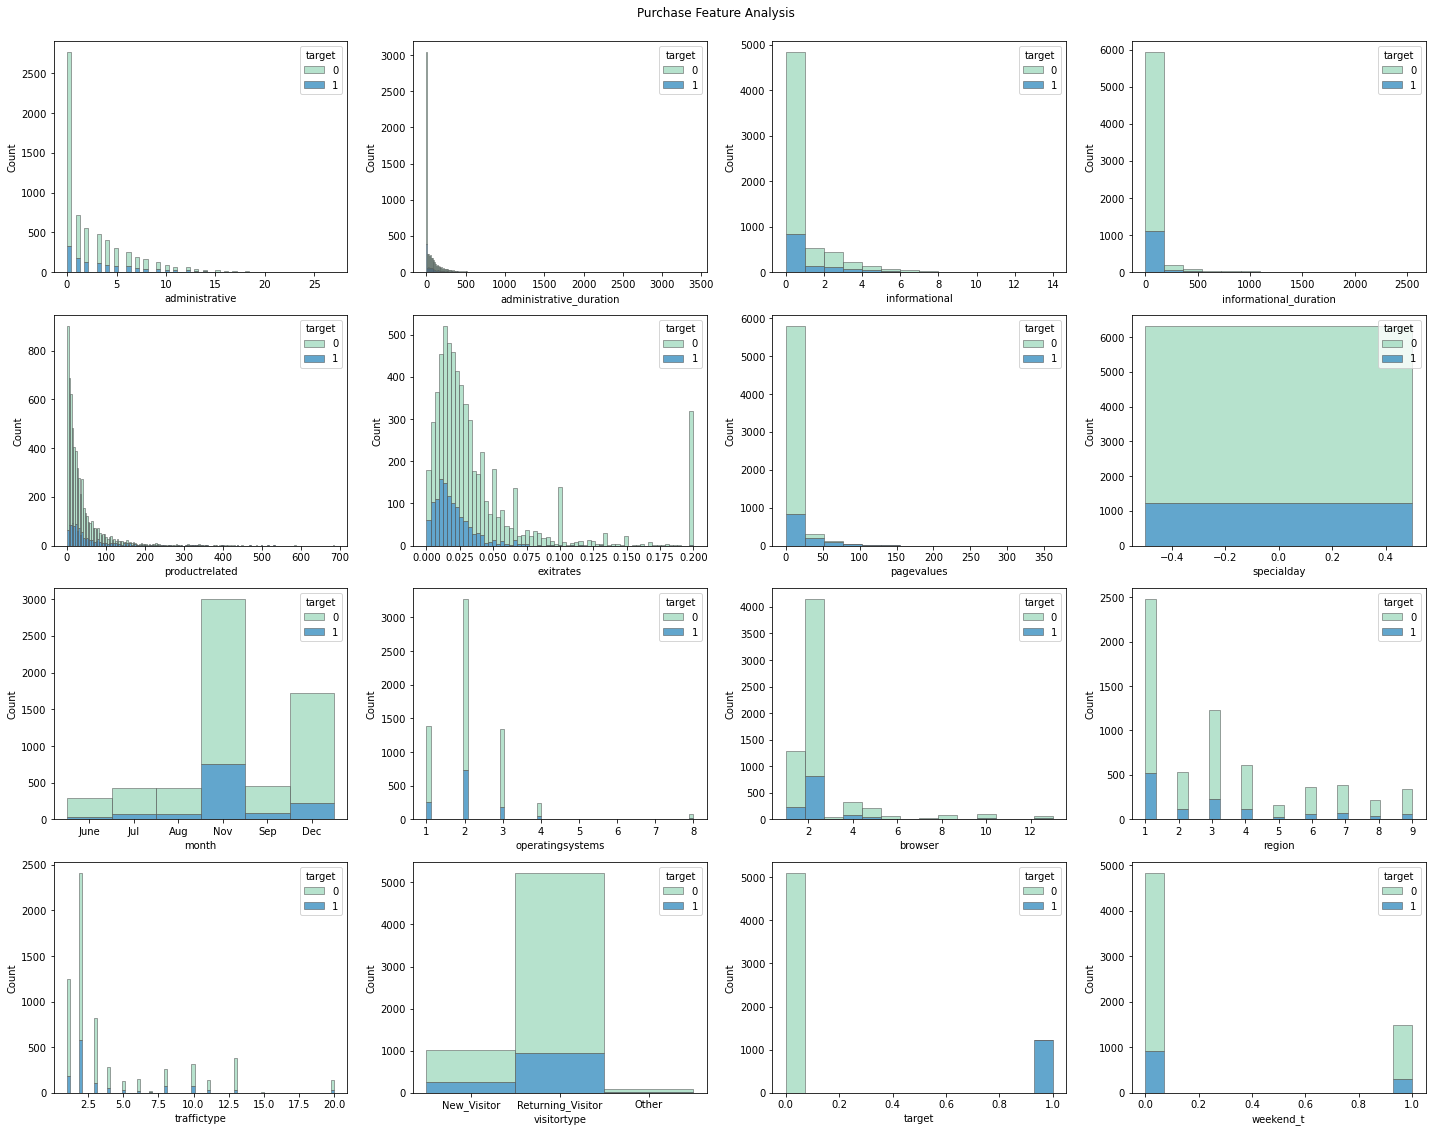

In [13]:
selected_columns = list(train.columns)

fig = plt.figure(figsize=(20, 16))
j = 0
for i in selected_columns:
    plt.subplot(4, 4, j+1)
    j += 1
    sns.histplot(data=train, x=i, hue='target', multiple='stack', palette='YlGnBu', edgecolor='.3', linewidth=.5, alpha=.7)
fig.suptitle('Purchase Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

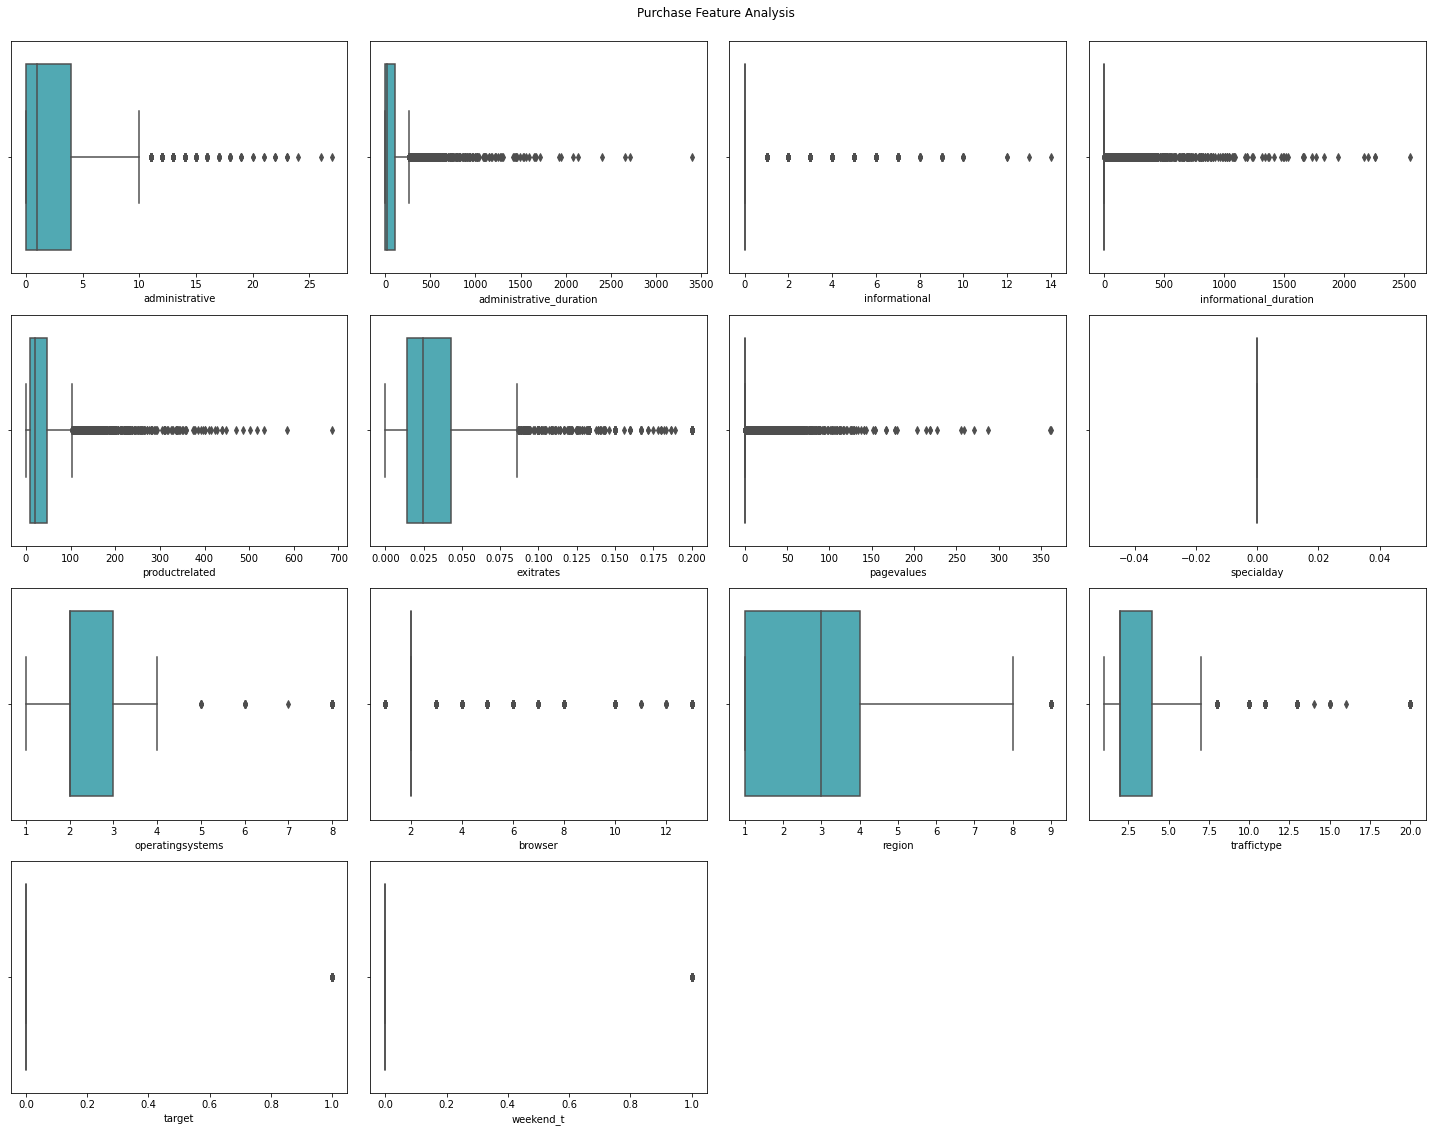

In [14]:
selected_columns = list(train.select_dtypes('number').columns)

fig = plt.figure(figsize=(20, 16))
j = 0
for i in selected_columns:
    plt.subplot(4, 4, j+1)
    j += 1
    sns.boxplot(data=train, x=i, palette='YlGnBu')
fig.suptitle('Purchase Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

#### Data Preprocessing

In [15]:
# constants for the preprocessing pipeline
SCALING_COLUMNS = [
    'administrative', 
    'administrative_duration', 
    'informational', 
    'informational_duration', 
    'productrelated',
    'exitrates',
    'pagevalues',
    'specialday',
]
ONE_HOT_COLUMNS = [
    'operatingsystems', 
    'browser', 
    'region', 
    'traffictype',
    'visitortype'
]

def preprocess_dataset(dataset: pd.DataFrame, scaler) -> pd.DataFrame:
    '''
    Conducts column transformations and word-2-vector conversion on the cleansed review text.

    Parameters
    ----------
    dataset : pd.DataFrame
        The cleansed dataset.

    Returns
    -------
    pd.DataFrame
        The final, pre-processed dataset.
    '''
    df = dataset.copy()
    original_dataset_length = len(df)

    # handle month ordinal encoding
    def _convert_month_name_to_ordinal(month_name: str) -> int:
        mapping = {
            'Feb': 2,
            'Mar': 3,
            'June': 6, 
            'Jul': 7, 
            'Aug': 8, 
            'Sep': 9, 
            'Oct': 10,
            'Nov': 11, 
            'Dec': 12
        }
        return mapping[month_name]
    encoded_months = pd.Series(df['month'].apply(lambda m: _convert_month_name_to_ordinal(m)))

    # handle scaling transformations
    scaler_transformer = ColumnTransformer([
        ('scaler', scaler, SCALING_COLUMNS),
    ], verbose_feature_names_out=True)
    scaler_transformer.fit(df)
    scaler_transformed = pd.DataFrame(scaler_transformer.transform(df), columns=[col + '_t' for col in SCALING_COLUMNS])

    # handle one-hot-encoding transformations
    ohe_transformed = pd.get_dummies(dataset[ONE_HOT_COLUMNS])
    ohe_transformed.columns = [col.lower() for col in list(ohe_transformed.columns)]

    df = pd.concat(
        objs=[
            encoded_months, 
            scaler_transformed, 
            ohe_transformed
        ], axis=1)

    assert len(df) == original_dataset_length

    return df

In [16]:
# fully partition into train and test sets and encode the target as an int
X_train = train.drop('target', axis=1)
y_train = train['target'].values.astype(int)
X_test = test.drop('target', axis=1)
y_test = test['target'].values.astype(int)

# reset axes
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

print('Datasets after splitting')
print('------------------------')
print(f'X_train has shape: {X_train.shape}')
print(f'X_test has shape: {X_test.shape}')
print(f'y_train has shape: {y_train.shape}')
print(f'y_test has shape: {y_test.shape}')
print()

# preprocess the datasets
print('Datasets after processing')
print('-------------------------')
X_train = preprocess_dataset(X_train, MinMaxScaler())
X_test = preprocess_dataset(X_test, MinMaxScaler())
print(f'Processed X_train has shape: {X_train.shape}')
print(f'Processed X_test has shape: {X_test.shape}')

# insert missing columns into X_test at the proper location
column_differences = list(set(X_train.columns) - set(X_test.columns))
column_differences

for column in column_differences:
    X_test.insert(loc=list(X_train.columns).index(column), column=column, value=np.zeros(len(X_test)))
assert len(X_train.columns) == len(X_test.columns), 'Featurespaces are different between train and test!'

Datasets after splitting
------------------------
X_train has shape: (6326, 15)
X_test has shape: (2091, 15)
y_train has shape: (6326,)
y_test has shape: (2091,)

Datasets after processing
-------------------------
Processed X_train has shape: (6326, 16)
Processed X_test has shape: (2091, 15)


#### Model Fitting & Evaluation

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

##### Logistic Regression

In [18]:
# build cross-validated predictions on a logistic regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_pred = cross_val_predict(estimator=lr_model, X=X_train, y=y_train)

In [19]:
print('classification metrics')
print('----------------------')
print('accuracy:', accuracy_score(y_train, lr_pred))
print('precision:', precision_score(y_train, lr_pred))
print('recall:', recall_score(y_train, lr_pred))
print('f1 score:', f1_score(y_train, lr_pred))
print('roc score:', roc_auc_score(y_train, lr_pred))
print()
print('confusion matrix')
print('----------------')
print(confusion_matrix(y_train, lr_pred))
print()
print('classification report')
print('---------------------')
print(classification_report(y_train, lr_pred))

classification metrics
----------------------
accuracy: 0.7725260828327537
precision: 0.4467425025853154
recall: 0.7007299270072993
f1 score: 0.5456267761288286
roc score: 0.7453188217404453

confusion matrix
----------------
[[4023 1070]
 [ 369  864]]

classification report
---------------------
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      5093
           1       0.45      0.70      0.55      1233

    accuracy                           0.77      6326
   macro avg       0.68      0.75      0.70      6326
weighted avg       0.82      0.77      0.79      6326



In [20]:
# make predictions
lr_model.fit(X_train, y_train)
lr_pred_test = lr_model.predict(X_test)

In [21]:
print('classification metrics')
print('----------------------')
print('accuracy:', accuracy_score(y_test, lr_pred_test))
print('precision:', precision_score(y_test, lr_pred_test))
print('recall:', recall_score(y_test, lr_pred_test))
print('f1 score:', f1_score(y_test, lr_pred_test))
print('roc score:', roc_auc_score(y_test, lr_pred_test))
print()
print('confusion matrix')
print('----------------')
print(confusion_matrix(y_test, lr_pred_test))
print()
print('classification report')
print('---------------------')
print(classification_report(y_test, lr_pred_test))

classification metrics
----------------------
accuracy: 0.8417025346724055
precision: 0.3645418326693227
recall: 0.9384615384615385
f1 score: 0.5251076040172167
roc score: 0.8851062966569295

confusion matrix
----------------
[[1577  319]
 [  12  183]]

classification report
---------------------
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      1896
           1       0.36      0.94      0.53       195

    accuracy                           0.84      2091
   macro avg       0.68      0.89      0.72      2091
weighted avg       0.93      0.84      0.87      2091



##### Random Forest

In [22]:
# build cross-validated predictions on a random forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_pred = cross_val_predict(estimator=rf_model, X=X_train, y=y_train)

In [23]:
print('classification metrics')
print('----------------------')
print('accuracy:', accuracy_score(y_train, rf_pred))
print('precision:', precision_score(y_train, rf_pred))
print('recall:', recall_score(y_train, rf_pred))
print('f1 score:', f1_score(y_train, rf_pred))
print('roc score:', roc_auc_score(y_train, rf_pred))
print()
print('confusion matrix')
print('----------------')
print(confusion_matrix(y_train, rf_pred))
print()
print('classification report')
print('---------------------')
print(classification_report(y_train, rf_pred))

classification metrics
----------------------
accuracy: 0.8601011697755295
precision: 0.7047058823529412
recall: 0.48580697485806973
f1 score: 0.5751320211233797
roc score: 0.7182618223986009

confusion matrix
----------------
[[4842  251]
 [ 634  599]]

classification report
---------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      5093
           1       0.70      0.49      0.58      1233

    accuracy                           0.86      6326
   macro avg       0.79      0.72      0.75      6326
weighted avg       0.85      0.86      0.85      6326



In [24]:
# make predictions
rf_model.fit(X_train, y_train)
rf_pred_test = lr_model.predict(X_test)

In [25]:
print('classification metrics')
print('----------------------')
print('accuracy:', accuracy_score(y_test, rf_pred_test))
print('precision:', precision_score(y_test, rf_pred_test))
print('recall:', recall_score(y_test, rf_pred_test))
print('f1 score:', f1_score(y_test, rf_pred_test))
print('roc score:', roc_auc_score(y_test, rf_pred_test))
print()
print('confusion matrix')
print('----------------')
print(confusion_matrix(y_test, rf_pred_test))
print()
print('classification report')
print('---------------------')
print(classification_report(y_test, rf_pred_test))

classification metrics
----------------------
accuracy: 0.8417025346724055
precision: 0.3645418326693227
recall: 0.9384615384615385
f1 score: 0.5251076040172167
roc score: 0.8851062966569295

confusion matrix
----------------
[[1577  319]
 [  12  183]]

classification report
---------------------
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      1896
           1       0.36      0.94      0.53       195

    accuracy                           0.84      2091
   macro avg       0.68      0.89      0.72      2091
weighted avg       0.93      0.84      0.87      2091



Feature Ranking
---------------
1. pagevalues_t (feature 7) (0.317746)
2. exitrates_t (feature 6) (0.152409)
3. productrelated_t (feature 5) (0.123725)
4. administrative_duration_t (feature 2) (0.079605)
5. administrative_t (feature 1) (0.053276)
6. month (feature 0) (0.050477)
7. region (feature 11) (0.046976)
8. traffictype (feature 12) (0.046519)
9. informational_duration_t (feature 4) (0.033612)
10. operatingsystems (feature 9) (0.026892)
11. browser (feature 10) (0.026119)
12. informational_t (feature 3) (0.025632)
13. visitortype_returning_visitor (feature 15) (0.008431)
14. visitortype_new_visitor (feature 13) (0.008044)
15. visitortype_other (feature 14) (0.000538)
16. specialday_t (feature 8) (0.000000)


(-1.0, 16.0)

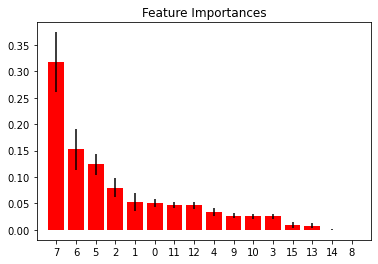

In [26]:
# use random forest to get feature ranks/importances for each feature
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature Ranking')
print('---------------')

for f in range(X_train.shape[1]):
    print("%d. %s (feature %d) (%f)" %
          (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])

#### Hyperparameter-Tuning

In [27]:
# grid search on a handful of parameters and define the full pipeline
param_grid = {
    'max_depth': [5, 10, 20],
    'max_features': ['sqrt', 'log2', 'auto'],
}

gs_model = GridSearchCV(
    rf_model, 
    cv=5, 
    n_jobs=1, 
    param_grid=param_grid, 
    scoring='f1', 
    error_score='raise', 
    verbose=2
)

In [28]:
gs_model.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................max_depth=5, max_features=sqrt; total time=   0.6s
[CV] END .....................max_depth=5, max_features=sqrt; total time=   0.4s
[CV] END .....................max_depth=5, max_features=sqrt; total time=   0.5s
[CV] END .....................max_depth=5, max_features=sqrt; total time=   0.5s
[CV] END .....................max_depth=5, max_features=sqrt; total time=   0.4s
[CV] END .....................max_depth=5, max_features=log2; total time=   0.4s
[CV] END .....................max_depth=5, max_features=log2; total time=   0.4s
[CV] END .....................max_depth=5, max_features=log2; total time=   0.4s
[CV] END .....................max_depth=5, max_features=log2; total time=   0.4s
[CV] END .....................max_depth=5, max_features=log2; total time=   0.4s
[CV] END .....................max_depth=5, max_features=auto; total time=   0.4s
[CV] END .....................max_depth=5, max_fe

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [5, 10, 20],
                         'max_features': ['sqrt', 'log2', 'auto']},
             scoring='f1', verbose=2)

In [29]:
# output best estimator params
print(gs_model.best_params_)

{'max_depth': 5, 'max_features': 'sqrt'}


In [30]:
# output best score, params, and estimator
print(gs_model.best_score_)

0.6383394167567185


### 🔑 Answers to Questions for Task 1

[1] Fit a logistic regression and at least one other classification model. Find and explain important features.

Using a random forest classifier to extract the relative feature importances, we can see that `pagevalues` accounts for the highest importance score and thus is the best individual feature for explaining the whether a purchase results in a revenue indication. The next two most important features, after `pagevalues` are `exitrates` and `productrelated`. From this information, we can deduce that with a random forest model, the type of page the user visits contribute highly to the outcome of a purchase transaction or not.  


[2] Report and interpret the most meaningful classifications metrics

In looking at the cross-validated scores and predictions scores for a logistic regression model and random forest model, the most meaningful classification metrics are f1 score. This is due to the fact that we have an imbalanced dataset and thus, cannot rely on model accuracy as a good evaluation metric for our model's predictive power. Given that the "cost" to the business is likely the same for a model that predicts a purchase when one would not have been made OR a model that predicts no purchase when one would have been made, we'll use f1 score as a "tie-breaker" evaluation metric. What we observe in our experimentation is that a cross-validated random forest model performs better than logistic regression (f1 scores .58 and .55 respectively) and both models predict with the same f1 score on the target variable of interest (a revenue label of 1). For purposes of our problem, by focusing on f1 score, we're prioritizting the harmonic mean between precision and recall: not focusing too much on false positives or false negatives. 


[3] Show and explain the hyper-parameter fitting process.

For hyperparameter-tuning, we'll use grid search to create different combinations of model parameters. For this process, we'll focus on tuning 3 parameters:
- max (tree) depth: This parameter adjusts the maximim depth of individual trees in the bagging process. The deeper the tree, the more splits it has and the more information the trees use for modeling. A higher depth can lead to overfitting, so we tune this parameter to find an optimal f1 score for our model.
- max features: This parameter adjusts how many features are evaluated at each split during the tree-building process. The fewer the number of features available during tree-building, the less information available to each tree. This can help build different individual decision trees in a random forest since the features being used changes during bagging. This leads to more diversity in the trees of a random forest which will help lead to less overfitting and better generalization.

By tuning these few parameters (there are more we could add!), we're able to increase the cross-validated f1 score on our training set from .55 to .63 to "squeeze" out a bit more performance on our model with modest adjustments.

### Task 2. Classification (25 points)

Generate user-behavior clusters based on the purchasing behavior data for the complete dataset. 

1. How many clusters do you see? What are the significant differences between the various clusters in terms of the size of the clusters and purchase ratio. Perform as detailed analysis of the clusters as you can.
2. Return plots and cluster images generated for the data.
3. Perform a detailed analysis for each cluster corresponding to the variations in features and identify some behaviors corresponding to each particular cluster (e.g., which cluster represent new shoppers vs. brand conscious shoppers etc.).

Point breakdown:

- (15 points) Clustering code
- (10 points) Clustering analysis

#### Data Preprocessing

In [31]:
# reassemble the training and test sets since we're doing unsupervised learning
X = pd.concat([X_train, X_test])
y = np.append(y_train, y_test)
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (8417, 16)
y shape: (8417,)


#### Dimensionality Reduction

In [32]:
# reduce dimensionality
pca = PCA(n_components=3)
pca.fit(X)
X_reduced = pca.transform(X)
X_reduced

array([[-3.7499658 ,  1.20735545, -0.85916984],
       [ 5.69425997,  5.10508051,  2.13244462],
       [-3.36986555,  1.27821509,  4.0343945 ],
       ...,
       [-2.53050732,  4.8714782 ,  4.23703673],
       [-3.11456583,  4.76752389, -1.92742737],
       [-4.82539644,  4.03352954, -1.46191123]])

#### Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

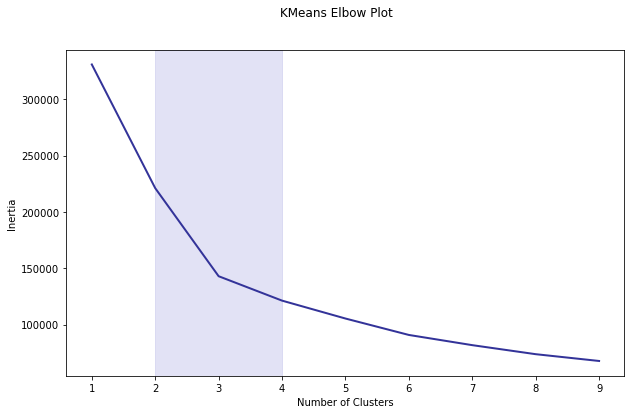

In [33]:
# iteratively calculate the inertia for increasing number of clusters
inertias = []

n_clusters = 10
n = list(range(1, n_clusters))

for i in n:
	clf = KMeans(n_clusters=i)
	clf.fit(X=X)
	inertias.append(clf.inertia_)

# plot the elbow plot
fig, ax = plt.subplots(1, figsize=(10, 6))
ax = sns.lineplot(x=n, y=inertias, color='#333399', linewidth=2)
ax.axvspan(2, 4, alpha=0.5, color='#c6c6ec')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Inertia')
plt.suptitle(f'KMeans Elbow Plot')
plt.show

For n_clusters = 2 The average silhouette_score is : 0.46826621391492607
For n_clusters = 3 The average silhouette_score is : 0.48110239481760325
For n_clusters = 4 The average silhouette_score is : 0.45380928547695487
For n_clusters = 5 The average silhouette_score is : 0.47082509575045806
For n_clusters = 6 The average silhouette_score is : 0.48743538866962605
For n_clusters = 7 The average silhouette_score is : 0.4682900500725075
For n_clusters = 8 The average silhouette_score is : 0.48414627959996964
For n_clusters = 9 The average silhouette_score is : 0.48247324935734476
For n_clusters = 10 The average silhouette_score is : 0.44308045904893517


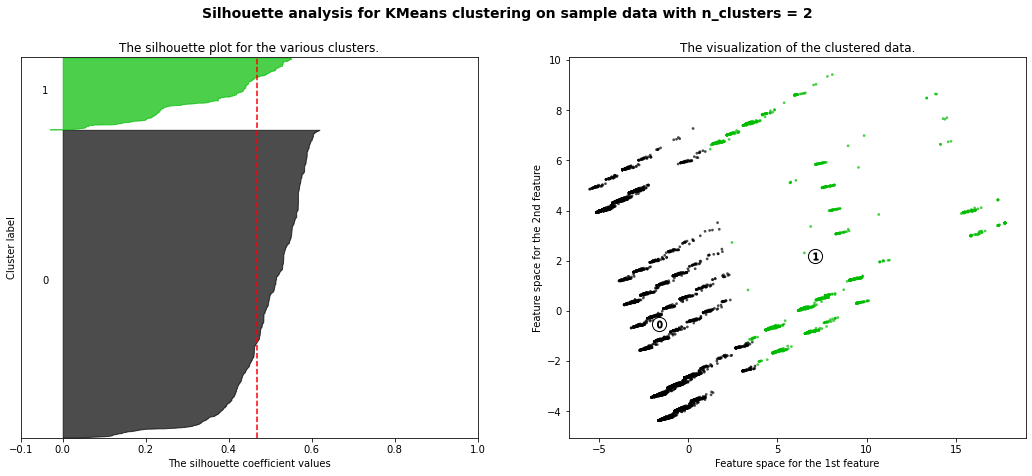

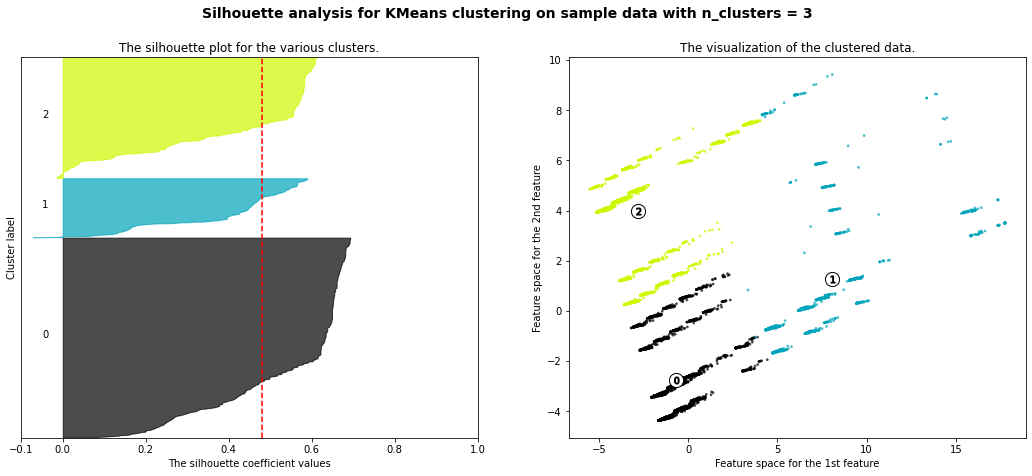

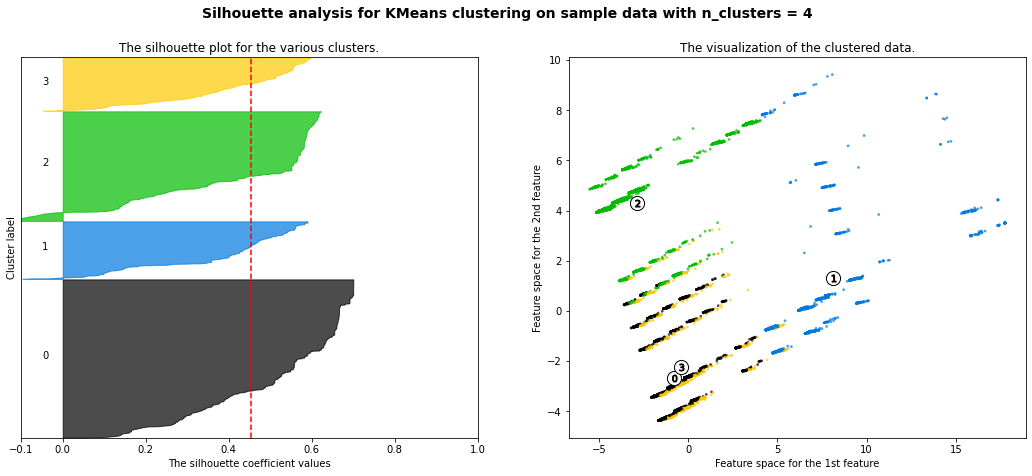

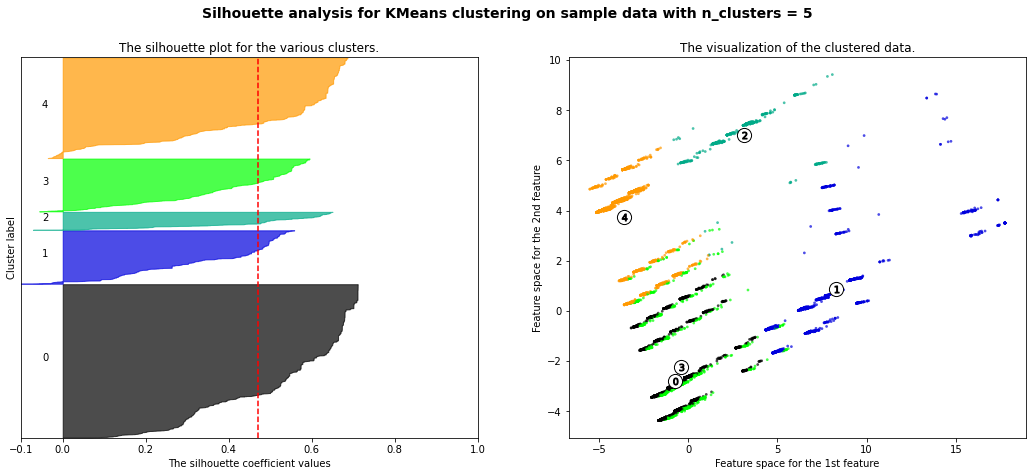

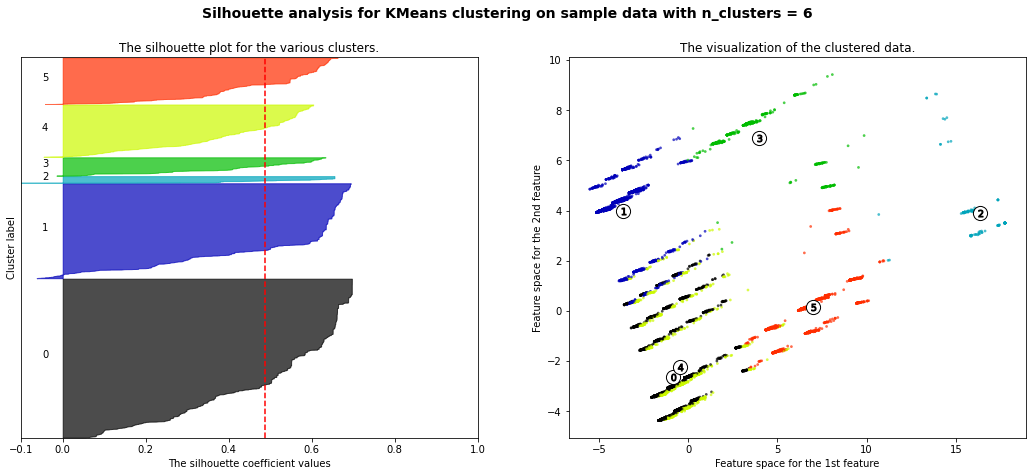

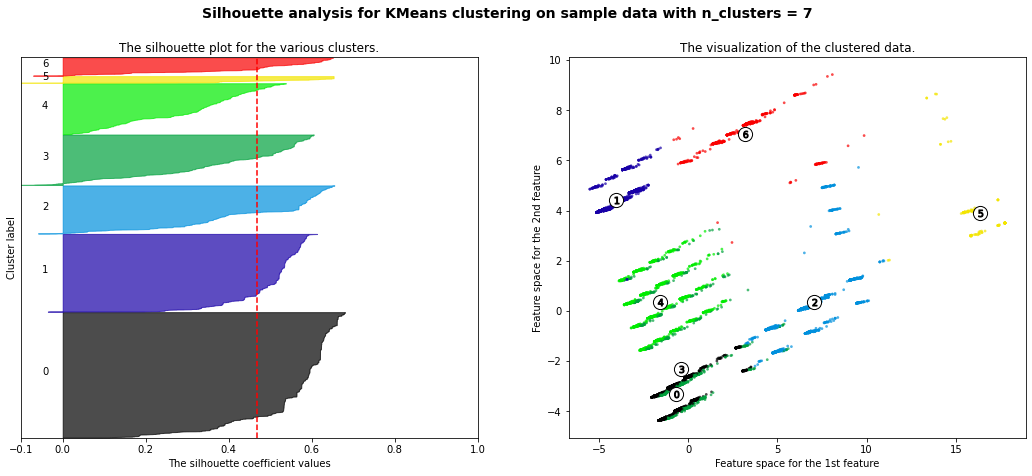

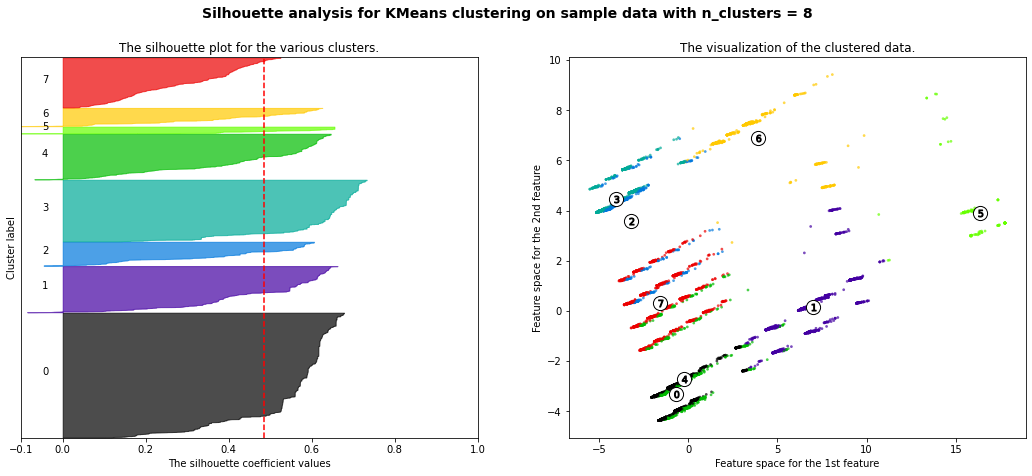

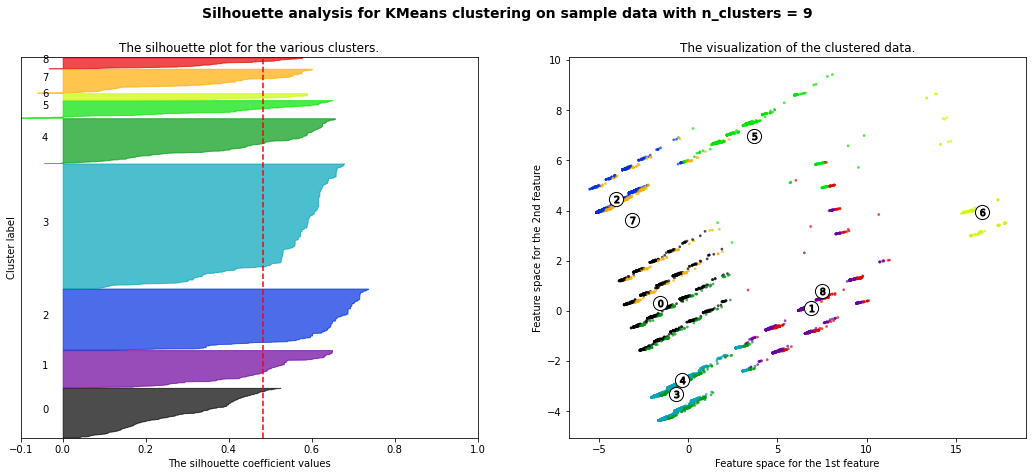

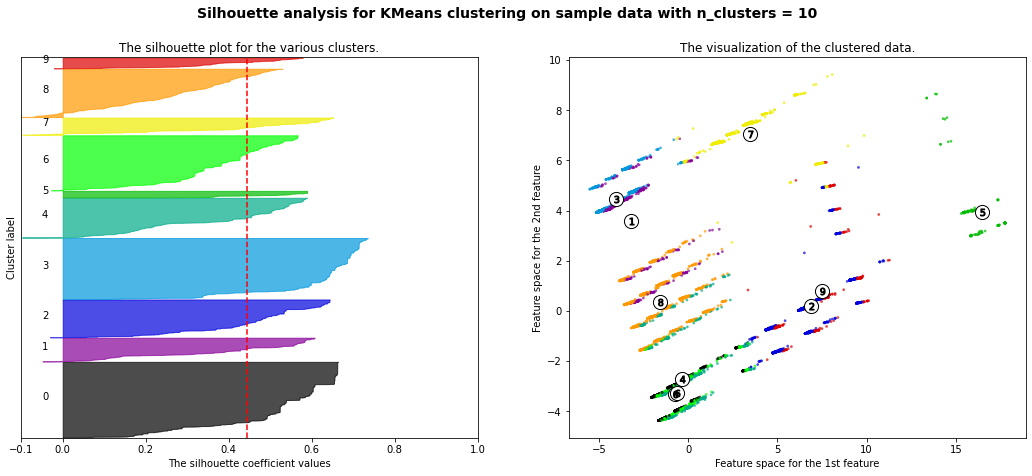

In [34]:
# visualize silhouette plots
visualize_silhouette(max_clusters=10, X=X_reduced)

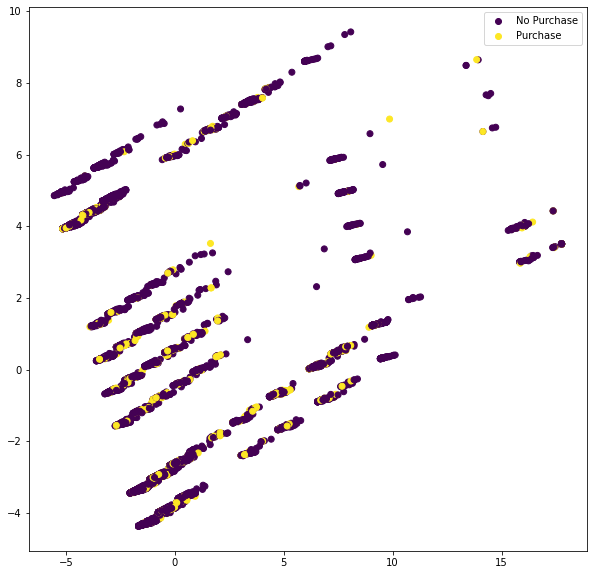

In [35]:
def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No Purchase', 'Purchase'])

visualize_2pcs(X_reduced, y=y)

#### Clustering

In [36]:
# assign cluster assignments to a dataframe and generate counts
kmeans = KMeans(n_clusters=3)
kmeans.fit_transform(X_reduced)
labels = kmeans.labels_.tolist()
cluster_assignments = pd.DataFrame(labels, columns=['cluster'])
cluster_assignments['cluster'].value_counts()

0    4440
2    2668
1    1309
Name: cluster, dtype: int64

In [37]:
# assign clusters to data
cluster_data = pd.concat([train, test], axis=0)
cluster_data['cluster'] = labels
cluster_data['target'] = y
cluster_data

,administrative,administrative_duration,informational,informational_duration,productrelated,exitrates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype,target,weekend_t,cluster
5456,3,40.200000,0,0.0,11,0.020000,0.000000,0.0,June,2,2,2,1,New_Visitor,0,0,2
5458,6,618.066667,0,0.0,50,0.004386,28.068050,0.0,June,2,2,6,11,New_Visitor,1,0,1
5459,0,0.000000,0,0.0,2,0.100000,0.000000,0.0,June,2,2,7,1,Returning_Visitor,0,0,2
5460,3,152.600000,0,0.0,28,0.031250,19.827709,0.0,Jul,2,2,7,13,Returning_Visitor,1,0,1
5462,0,0.000000,0,0.0,20,0.068254,0.000000,0.0,Aug,3,2,3,3,Returning_Visitor,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,1,78.000000,0,0.0,21,0.002381,24.750476,0.0,Mar,1,1,1,2,New_Visitor,1,0,2
2087,0,0.000000,0,0.0,19,0.005263,0.000000,0.0,Mar,2,4,1,3,Returning_Visitor,0,1,2
2088,0,0.000000,0,0.0,10,0.020000,0.000000,0.0,Mar,2,4,7,3,Returning_Visitor,0,0,2
2089,0,0.000000,0,0.0,1,0.200000,0.000000,0.0,Mar,3,2,1,3,Returning_Visitor,0,1,2


In [38]:
# purchase ratios
cluster_data[['cluster', 'target']].groupby('cluster').agg(
    purchases=('target', 'sum'),
    total=('target', 'count'),
    purchase_ratio=('target', 'mean')
)

,purchases,total,purchase_ratio
cluster,,,
0,895,4440,0.201577
1,252,1309,0.192513
2,281,2668,0.105322


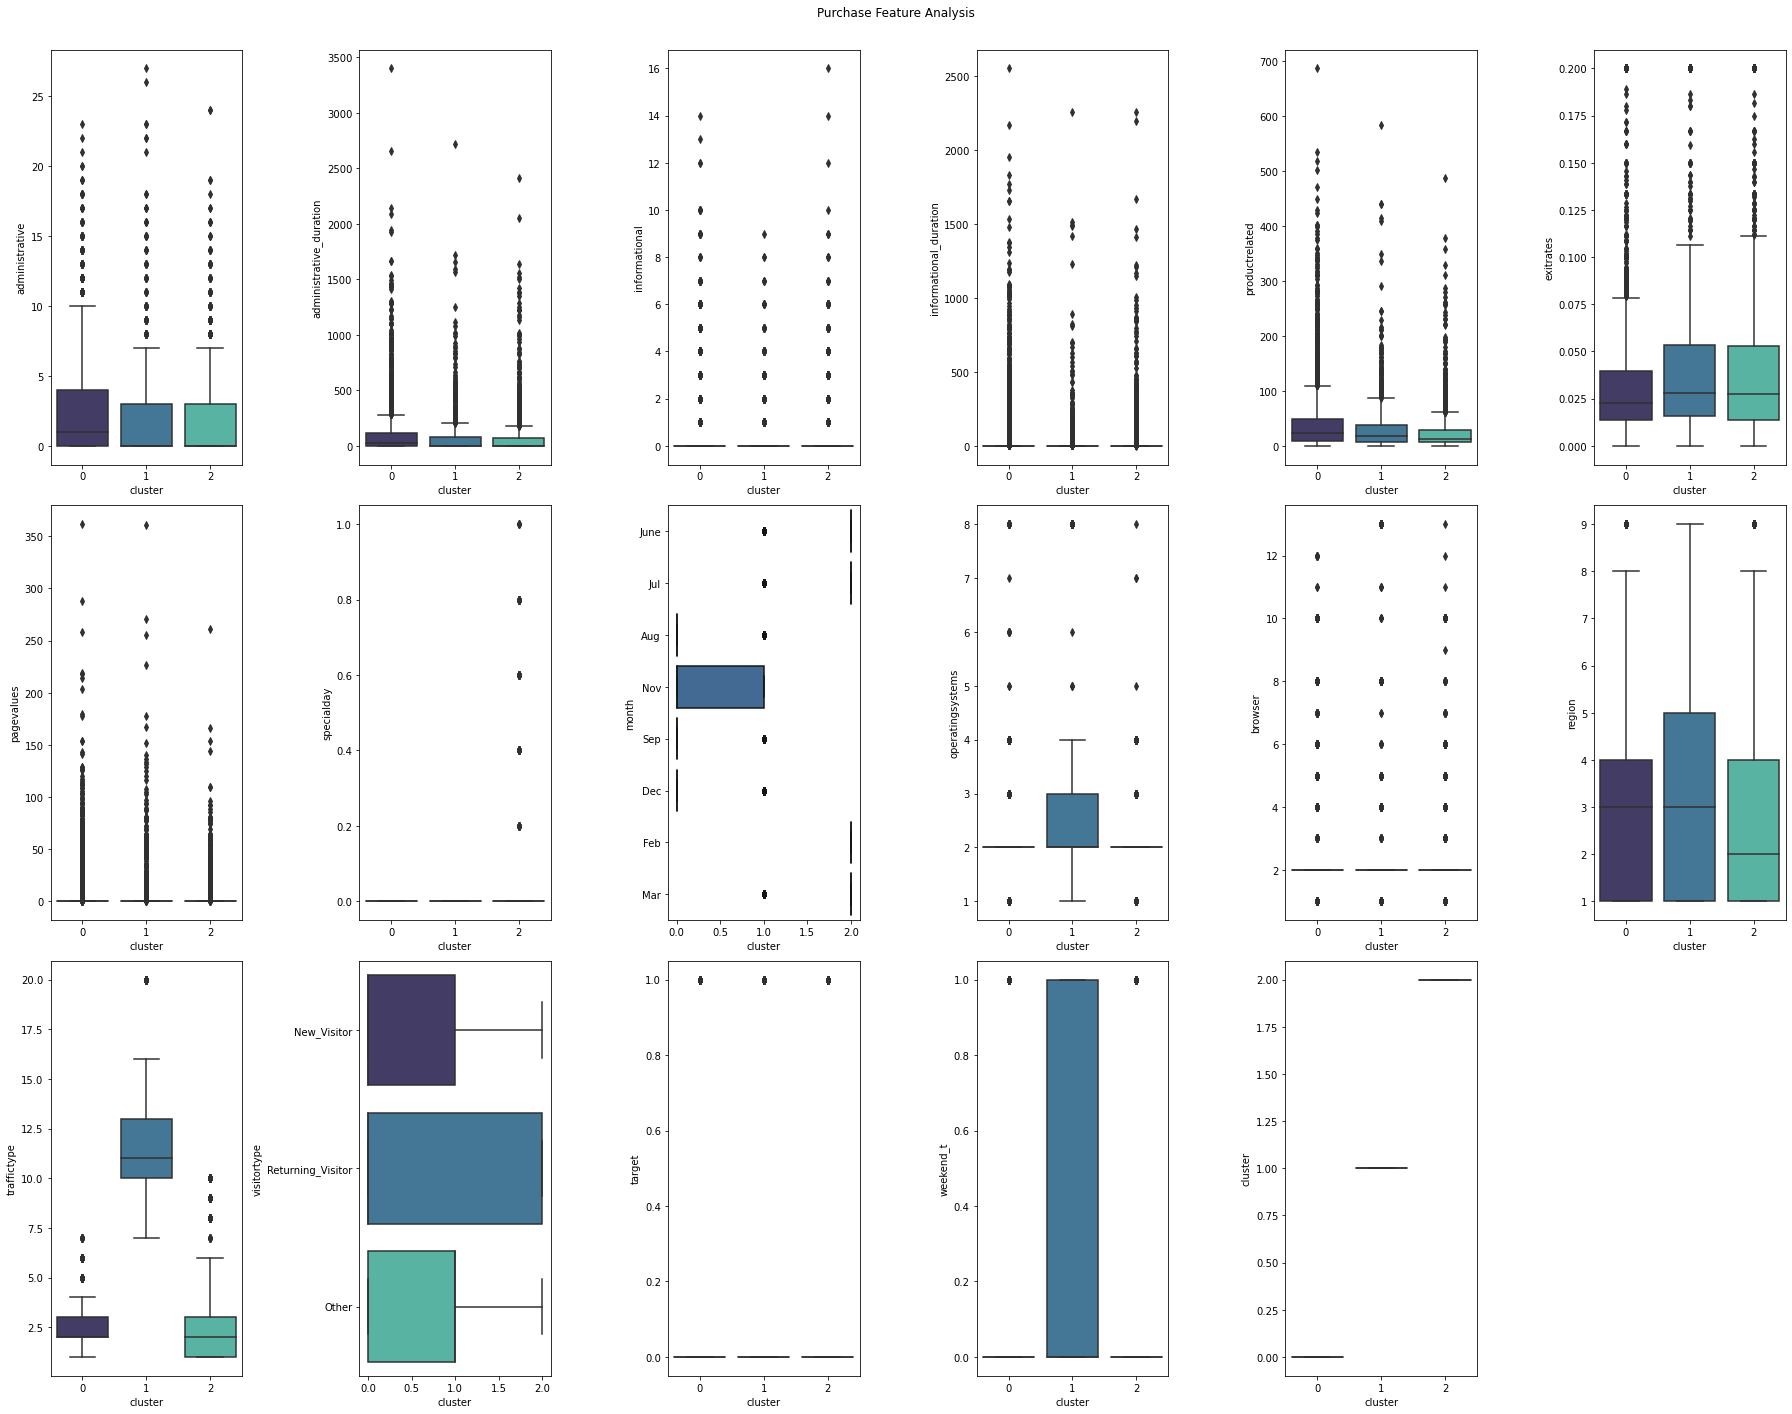

In [39]:
# create a list of columns to evaluate against the cluster
analysis_columns = list(cluster_data.columns)

fig = plt.figure(figsize=(25, 20))
j = 0
for i in analysis_columns:
    plt.subplot(3, 6, j+1)
    j += 1
    sns.boxplot(data=cluster_data, x='cluster', y=i, palette='mako')
fig.suptitle('Purchase Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

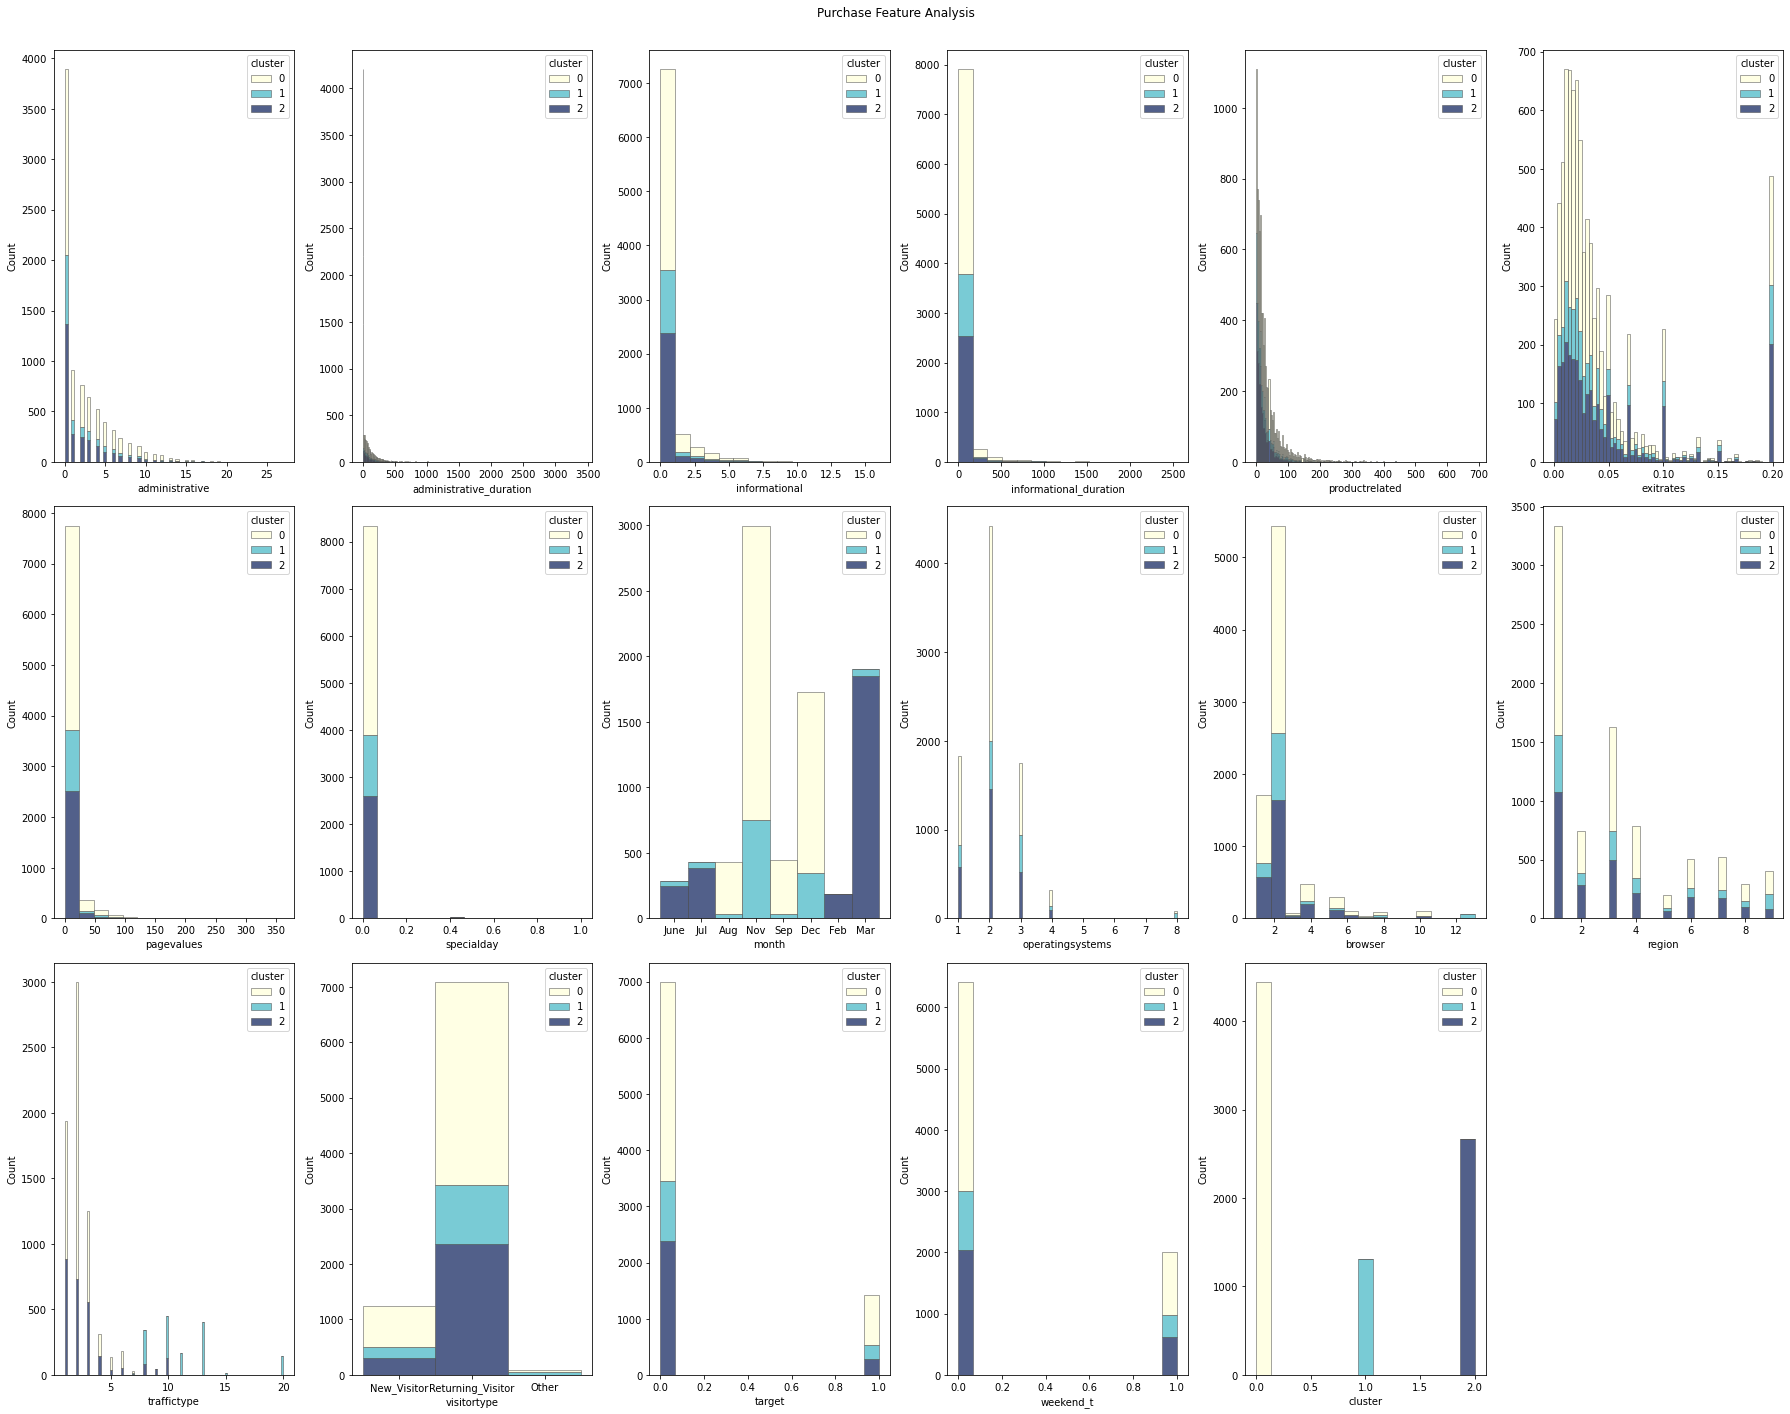

In [40]:
# create a list of columns to evaluate against the cluster
fig = plt.figure(figsize=(25, 20))
j = 0
for i in analysis_columns:
    plt.subplot(3, 6, j+1)
    j += 1
    sns.histplot(data=cluster_data, x=i, hue='cluster', multiple='stack', palette='YlGnBu', edgecolor='.3', linewidth=.5, alpha=.7)
fig.suptitle('Purchase Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

### 🔑 Answers to Questions for Task 2

(1) How many clusters do you see? What are the significant differences between the various clusters in terms of the size of the clusters and purchase ratio. Perform as detailed analysis of the clusters as you can.

When looking at the visualizations of the clustered data in the silhouette plots as well as the 2-D plot, we can make the argument that there exists approximately 4-5 different plots. It's difficult to estimate the plots visually, since we see distinct clusters of "bands" in the visualizations, therefore, we'll turn to metrics to address our question. Through the "elbow plot", we can see that the number of clusters where we observe the reduction in inertia diminishing is anywhere from 2-4 cluster. Intertia can be viewed as the "tightness" of points within a cluster, since inertia is the weighted mean of the square distances between points of a cluster and the cluster's centroid. Furthremore, by analyzing the silhouette plots and associated silhouette scores, we can see several cluster sizes with approximately the same silhouette score (around .48). Silhouette scores represent the "goodness" of clustering for the number of clusters, `n`. Given we have so many similary silhouette scores, we can make the case that explaining differences between a fewer number of clustered customers has easier explainability to a non-technical audience.

With 3 clusters (what our "elbow plot" and silhouette analysis recommend), we see 2668 customers in cluster 0, 4440 customers in cluster 1, and 1309 customers in cluster 2.


(2) Return plots and cluster images generated for the data.

👀 See plots above.


(3) Perform a detailed analysis for each cluster corresponding to the variations in features and identify some behaviors corresponding to each particular cluster (e.g., which cluster represent new shoppers vs. brand conscious shoppers etc.).

- Customers in cluster 2 have a tendency to shop primarily in the Thanksgivig to Christmas holiday season
- 🤷🏻‍♂️

### Task 3. Semi-Supervised Learning (15 points)

Consider you have training data with the `Revenue` attribute for records from June—September only. For all records from October—December, however, `Revenue` attribute is missing. Build a semi-supervised self-labeling model to estimate `Revenue` for the missing records in October—December and then fit your classifier. Report classification performance on February—March data set with and without the self-labeled data.

1. If you do not consider the records from October—December, generate the classification performance on test data
2. After using the self-labeled data and training data together, does the classification performance on test data improve? Discuss which metrics are most important for your conclusion.

Point breakdown:

- (2 points) Correctly splits the data by month into labeled, unlabeled, and test 
- (8 points) Generate labels for unlabeled samples with a self labeling technique
- (5 points) Compare and contrast performance difference on test dataset between labels only and labels & self-labels

#### Data Preprocessing & Partitioning

In [41]:
# recreate data for semi-supervised learning
def split_for_semi_supervised(dataset: pd.DataFrame) -> dict:
    
    df = dataset.copy()
    # split on specified months for semi-supervised learning

    train = df[df['month'].isin(['June', 'Jul', 'Aug', 'Nov', 'Sep'])]
    missing = df[df['month'].isin(['Oct', 'Nov', 'Dec'])]
    test = df[df['month'].isin(['Feb', 'Mar'])]

    # pre-convert the booleans as integers
    train_targets = pd.Series(train['revenue'].astype(int), name='target')
    train_weekends = pd.Series(train['weekend'].astype(int), name='weekend_t')
    train = pd.concat([train, train_targets, train_weekends], axis=1)
    train.drop(['revenue', 'weekend'], axis=1, inplace=True)

    missing_targets = pd.Series(missing['revenue'].astype(int), name='target')
    missing_weekends = pd.Series(missing['weekend'].astype(int), name='weekend_t')
    missing = pd.concat([missing, missing_targets, missing_weekends], axis=1)
    missing.drop(['revenue', 'weekend'], axis=1, inplace=True)

    test_targets = pd.Series(test['revenue'].astype(int), name='target')
    test_weekends = pd.Series(test['weekend'].astype(int), name='weekend_t')
    test = pd.concat([test, test_targets, test_weekends], axis=1)
    test.drop(['revenue', 'weekend'], axis=1, inplace=True)

    # drop the secondary features
    train = train.drop(['productrelated_duration', 'bouncerates'], axis=1)
    missing = missing.drop(['productrelated_duration', 'bouncerates'], axis=1)
    test = test.drop(['productrelated_duration', 'bouncerates'], axis=1)

    train_features = train.drop('target', axis=1)
    missing_features = missing.drop('target', axis=1)
    test_features = test.drop('target', axis=1)

    train_labels = train['target'].values.astype(int)
    missing_labels = np.negative(np.ones(len(missing)))
    test_labels = test['target'].values.astype(int)

    # reset indexes so preprocessing doesn't error
    train_features.reset_index(drop=True, inplace=True)
    missing_features.reset_index(drop=True, inplace=True)
    test_features.reset_index(drop=True, inplace=True)

    # preprocess the data
    train_features = preprocess_dataset(train_features, MinMaxScaler())
    missing_features = preprocess_dataset(missing_features, MinMaxScaler())
    test_features = preprocess_dataset(test_features, MinMaxScaler())

    # insert missing columns into test at the proper location
    for column in list(set(missing_features.columns) - set(test_features.columns)):
        test_features.insert(loc=list(missing_features.columns).index(column), column=column, value=np.zeros(len(test_features)))
    assert len(missing_features.columns) == len(test_features.columns), 'Featurespaces are different between train and test!'

    # convert to numpy arrays
    train_features = train_features.values
    missing_features = missing_features.values
    test_features = test_features.values

    assert isinstance(train_features, np.ndarray), 'train data is not numpy array!'
    assert isinstance(missing_features, np.ndarray), 'missing data is not numpy array!'
    assert isinstance(test_features, np.ndarray), 'test data is not numpy array!'
    assert isinstance(train_labels, np.ndarray), 'train labels is not numpy array!'
    assert isinstance(missing_labels, np.ndarray), 'missing labels is not numpy array!'
    assert isinstance(test_labels, np.ndarray), 'test labels is not numpy array!'

    print(f'Processed train_features has shape: {train_features.shape}')
    print(f'Processed missing_features has shape: {missing_features.shape}')
    print(f'Processed test_features has shape: {test_features.shape}')
    print()
    print(f'Processed train_labels has shape: {train_labels.shape}')
    print(f'Processed missing_labels has shape: {missing_labels.shape}')
    print(f'Processed test_labels has shape: {test_labels.shape}')

    return (
        train_features,
        missing_features,
        test_features,
        train_labels,
        missing_labels,
        test_labels,
    )

In [42]:
# do data splitting
X_train, X_missing, X_test, y_train, y_missing, y_test = split_for_semi_supervised(df)

Processed train_features has shape: (4599, 16)
Processed missing_features has shape: (5274, 16)
Processed test_features has shape: (2091, 16)

Processed train_labels has shape: (4599,)
Processed missing_labels has shape: (5274,)
Processed test_labels has shape: (2091,)


#### Generate Labels

In [50]:
# recombine data
X = np.append(X_train, X_missing, axis=0)
y = np.append(y_train, y_missing, axis=0)

(9873, 16)


In [57]:
# fit label-spreading and generate labels and get the labels for the test set
lp_model = LabelSpreading(kernel='knn', alpha=0.01).fit(X, y)
semi_sup_preds_test = lp_model.predict(X_test)

#### Fit Classifier & Compare Performance

In [59]:
# baseline on missing
lr_model = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1896
           1       0.82      0.21      0.33       195

    accuracy                           0.92      2091
   macro avg       0.87      0.60      0.64      2091
weighted avg       0.91      0.92      0.90      2091



In [60]:
# model using semi-supervised labels
print(classification_report(y_test, semi_sup_preds_test))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1896
           1       0.00      0.00      0.00       195

    accuracy                           0.90      2091
   macro avg       0.45      0.50      0.47      2091
weighted avg       0.82      0.90      0.86      2091

